<a href="https://colab.research.google.com/github/danielpcox/Bare-Bones-Platformer/blob/master/Transformers_ETH%2BBTC_1cycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [3]:
%%bash

pip install pandas_ta
git clone https://github.com/titu1994/keras-one-cycle.git
mv keras-one-cycle/*.py ./

  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=182e7d9610a2d8a950ba0e0a0faa8dc84a2eac7397b2ddba71c57e8f59f4088b
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


Cloning into 'keras-one-cycle'...


In [4]:
%tensorflow_version 2.x
import numpy as np
import pandas as pd
import pandas_ta as ta
from pathlib import Path
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.7.0


In [5]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.53.240.34:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.53.240.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.53.240.34:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Load data

In [6]:
%%bash

cat << 'EOF'  > download.sh
#!/bin/bash

scriptdir="$( cd -- "$(dirname "$0")" >/dev/null 2>&1 ; pwd -P )"
cd $scriptdir
market=$1
year=$2
data_type=$3
directory=${market}/${year}
mkdir -p ${directory} && true
for i in $(seq -f "%02g" 1 8) # only through August for now
do
  filename="${market}-${year}${i}.csv.gz"
  echo "Downloading https://download.gatedata.org/spot/${data_type}/${year}${i}/${filename}"
  curl -s -o ${directory}/${filename} https://download.gatedata.org/spot/${data_type}/${year}${i}/${filename}
  gunzip -f ${directory}/${filename}
done
EOF

chmod 755 download.sh

In [7]:
symbols = ['ETH_USDT', 'BTC_USDT']
for symbol in symbols:
  !./download.sh $symbol 2021 candlesticks_1h

In [34]:
dfs = []
for symbol in symbols:
  data_2021 = (Path(symbol)/'2021').glob('*.csv')

  months = []
  for file in data_2021:
      months.append(pd.read_csv(file,
                                parse_dates=['timestamp'],
                                date_parser=lambda epoch: pd.to_datetime(epoch, unit='s'),
                                index_col='timestamp',
                                names=['timestamp', 'volume', 'close', 'high', 'low', 'open']))
  df = pd.concat(months).sort_index()
  df = df[['open', 'high', 'low', 'close', 'volume']]
  # TODO tack this on at the end, once we've made our mega dataframe
  # df['time'] = pd.Series(index=df.index, data=(((df.index.astype(int) / 10**9)-1.6094e9)*1e-8).to_numpy())

  # Replace 0 to avoid dividing by 0 later on
  df['volume'].replace(to_replace=0, method='ffill', inplace=True)

  # df = df.loc['2021-01-01':'2021-01-07'] # DEBUG
  dfs.append(df)

  print("symbol:", symbol, "-"*20)
  print(df.shape)
  print(df.tail())
  print()
df = dfs[0]

symbol: ETH_USDT --------------------
(5831, 5)
                        open     high      low    close      volume
timestamp                                                          
2021-08-31 19:00:00  3414.00  3423.00  3395.58  3414.59  519.108840
2021-08-31 20:00:00  3414.66  3426.65  3384.48  3390.94  436.586251
2021-08-31 21:00:00  3391.19  3435.28  3377.78  3401.52  443.057755
2021-08-31 22:00:00  3401.51  3414.82  3371.43  3411.91  426.588019
2021-08-31 23:00:00  3412.94  3444.30  3400.29  3428.82  554.836207

symbol: BTC_USDT --------------------
(5831, 5)
                         open      high       low     close     volume
timestamp                                                             
2021-08-31 19:00:00  47303.97  47396.63  47193.68  47300.01  11.301451
2021-08-31 20:00:00  47300.18  47321.86  46919.07  47000.47  18.667201
2021-08-31 21:00:00  47000.48  47191.59  46841.00  46924.47  26.295528
2021-08-31 22:00:00  46925.21  47101.00  46764.01  47088.83  28.480914
2

In [35]:
all_indices_equal = True
for i in range(len(dfs)-1):
  if not dfs[i].index.equals(dfs[i+1].index):
    all_indices_equal = False
    print(f'Index of {symbols[i]} was not equal to {symbols[i+1]}')
if all_indices_equal:
  print("All df DatetimeIndexes are equal") 

All df DatetimeIndexes are equal


# Plot daily closing prices and volume

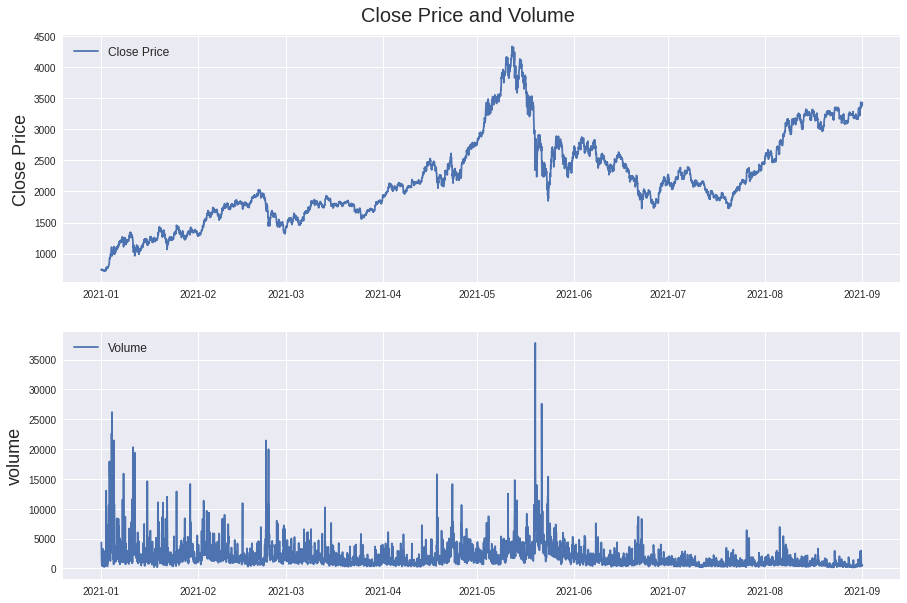

In [19]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['close'], label='Close Price')
# ax1.set_xticks(range(0, df.shape[0], 1464))
# ax1.set_xticklabels(df['timestamp'].loc[::1464])
# ax1.set_xticklabels(df.index.loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)
ax1.xaxis_date()

ax2 = fig.add_subplot(212)
ax2.plot(df['volume'], label='Volume')
# ax2.set_xticks(range(0, df.shape[0], 1464))
# ax2.set_xticklabels(df['timestamp'].loc[::1464])
# ax2.set_xticklabels(df.index.loc[::1464])
ax2.set_ylabel('volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)
ax2.xaxis_date()

# OHLCV -> normalized percent change

In [36]:
train_datas = []
val_datas = []
test_datas = []

for i,df in enumerate(dfs):
  print(symbols[i], "-"*50)

  '''Calculate percentage change'''
  df['open'] = df['open'].pct_change() # Create arithmetic returns column
  df['high'] = df['high'].pct_change() # Create arithmetic returns column
  df['low'] = df['low'].pct_change() # Create arithmetic returns column
  df['close'] = df['close'].pct_change() # Create arithmetic returns column
  df['volume'] = df['volume'].pct_change()

  # df.dropna(how='ffill', axis=0, inplace=True) # Drop all rows with NaN values
  # TODO is zero OK?
  df.fillna(value=0, inplace=True)

  ###############################################################################
  '''Create indexes to split dataset'''

  times = sorted(df.index.values)
  last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
  last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

  ###############################################################################
  '''Normalize price columns'''
  #
  min_return = min(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].min(axis=0))
  max_return = max(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].max(axis=0))

  # Min-max normalize price columns (0-1 range)
  df['open'] = (df['open'] - min_return) / (max_return - min_return)
  df['high'] = (df['high'] - min_return) / (max_return - min_return)
  df['low'] = (df['low'] - min_return) / (max_return - min_return)
  df['close'] = (df['close'] - min_return) / (max_return - min_return)

  ###############################################################################
  '''Normalize volume column'''

  min_volume = df[(df.index < last_20pct)]['volume'].min(axis=0)
  max_volume = df[(df.index < last_20pct)]['volume'].max(axis=0)

  # Min-max normalize volume columns (0-1 range)
  df['volume'] = (df['volume'] - min_volume) / (max_volume - min_volume)


ETH_USDT --------------------------------------------------
BTC_USDT --------------------------------------------------


eth                      ...       btc                    
                         open      high       low  ...       low     close    volume
timestamp                                          ...                              
2021-01-01 00:00:00  0.467478  0.467478  0.467478  ...  0.482888  0.482888  0.033314
2021-01-01 01:00:00  0.460079  0.500360  0.479457  ...  0.517839  0.535350  0.102868
2021-01-01 02:00:00  0.514710  0.467445  0.497906  ...  0.501400  0.456906  0.021474
2021-01-01 03:00:00  0.454501  0.462517  0.470614  ...  0.489831  0.492816  0.012200
2021-01-01 04:00:00  0.469575  0.466385  0.455317  ...  0.468108  0.475921  0.023544

[5 rows x 10 columns]

In [68]:
df = pd.concat(dfs, keys=symbols, axis=1)
df['Common', 'time'] = pd.DataFrame(data=pd.Series(index=df.index, data=(((df.index.astype(int) / 10**9)-1.6094e9)*1e-8).to_numpy()))
df.head()

ETH_USDT                      ...  BTC_USDT              Common
                         open      high       low  ...     close    volume      time
timestamp                                          ...                              
2021-01-01 00:00:00  0.467478  0.467478  0.467478  ...  0.482888  0.033314  0.000592
2021-01-01 01:00:00  0.460079  0.500360  0.479457  ...  0.535350  0.102868  0.000628
2021-01-01 02:00:00  0.514710  0.467445  0.497906  ...  0.456906  0.021474  0.000664
2021-01-01 03:00:00  0.454501  0.462517  0.470614  ...  0.492816  0.012200  0.000700
2021-01-01 04:00:00  0.469575  0.466385  0.455317  ...  0.475921  0.023544  0.000736

[5 rows x 11 columns]

In [69]:

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
# df_train.drop(columns=['Date'], inplace=True)
# df_val.drop(columns=['Date'], inplace=True)
# df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
# train_data = np.expand_dims(df_train.values, axis=1)
# val_data = np.expand_dims(df_val.values, axis=1)
# test_data = np.expand_dims(df_test.values, axis=1)
train_data = df_train.to_numpy()
val_data = df_val.to_numpy()
test_data = df_test.to_numpy()
# train_datas.append(this_train_data)
# val_datas.append(this_val_data)
# test_datas.append(this_test_data)


print("Training shape:", train_data.shape)
print("Validation shape:", val_data.shape)
print("Test shape:", test_data.shape)
print(df_train.head())
print()

Training shape: (4665, 11)
Validation shape: (583, 11)
Test shape: (583, 11)
                     ETH_USDT                      ...  BTC_USDT              Common
                         open      high       low  ...     close    volume      time
timestamp                                          ...                              
2021-01-01 00:00:00  0.467478  0.467478  0.467478  ...  0.482888  0.033314  0.000592
2021-01-01 01:00:00  0.460079  0.500360  0.479457  ...  0.535350  0.102868  0.000628
2021-01-01 02:00:00  0.514710  0.467445  0.497906  ...  0.456906  0.021474  0.000664
2021-01-01 03:00:00  0.454501  0.462517  0.470614  ...  0.492816  0.012200  0.000700
2021-01-01 04:00:00  0.469575  0.466385  0.455317  ...  0.475921  0.023544  0.000736

[5 rows x 11 columns]



# Plot daily changes of close prices and volume

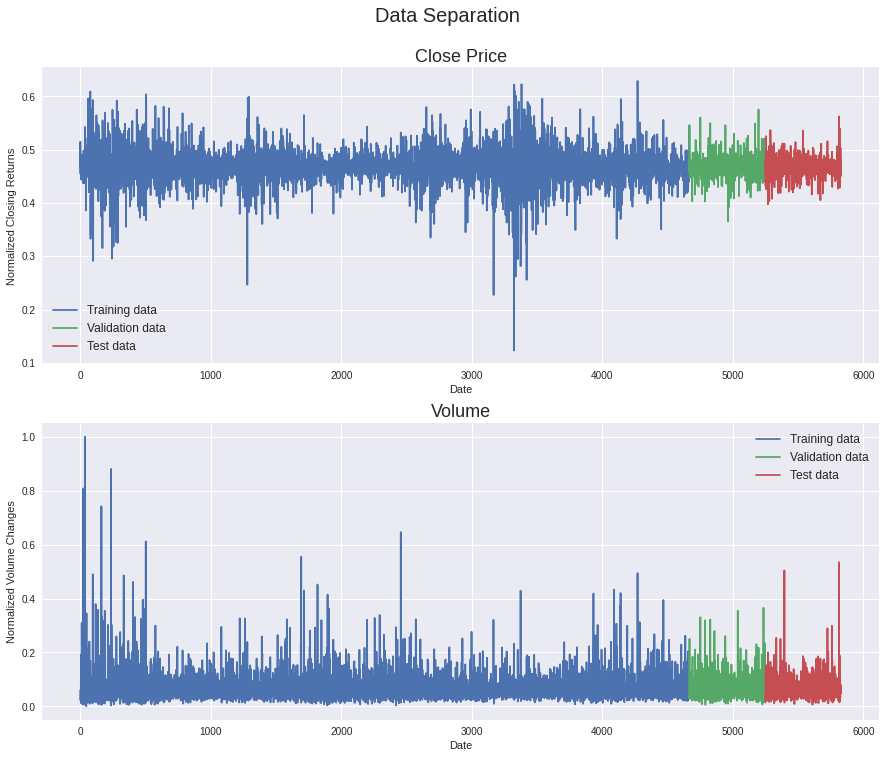

In [71]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['ETH_USDT', 'close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['ETH_USDT', 'close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['ETH_USDT', 'close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['ETH_USDT', 'volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['ETH_USDT', 'volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['ETH_USDT', 'volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

# Hyperparameters

In [77]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

num_samples = train_data.shape[0] - seq_len
num_features = train_data.shape[1]

# Create chunks of training, validation and test data

In [73]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i-1]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i-1])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i-1])    
X_test, y_test = np.array(X_test), np.array(y_test)


# X_train = X_train[:2] # DEBUG
# y_train = y_train[:2] # DEBUG
print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)


Training set shape (4537, 128, 11) (4537,)
Validation set shape (455, 128, 11) (455,)
Testing set shape (455, 128, 11) (455,)


# TimeVector

In [91]:
class Time2Vector(Layer):
  def __init__(self, k, **kwargs):
    super(Time2Vector, self).__init__()
    self.k = k

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(1, 1,),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(1, 1, 1,),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(1, self.k,),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(1, 1, self.k,),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    # last entry of last dimension is assumed to be a scalar time representation
    x = x[:,:,-1]
    x = tf.expand_dims(x, axis=-1)
    time_linear = tf.einsum('ijk,kl->ijl', x, self.weights_linear) + self.bias_linear
    print("time_linear shape", time_linear.shape) # DEBUG

    # looking for shape (None, 128, 2, k) - for each batch entry, for each item in the sequence, matmul
    time_periodic = tf.math.sin(tf.einsum('ijk,kl->ijl', x, self.weights_periodic) + self.bias_periodic)
    print("time_periodic shape", time_periodic.shape) # DEBUG
    out = tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, k+1)
    print("time2vec out shape", out.shape)
    return out
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'k': self.k})
    return config
  

# Transformer

In [79]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    # self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    # self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    # attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    # ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

# Model

In [92]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(k=3)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, num_features)) # 6 for ohlcv and time
  t = time_embedding(in_seq)
  print("t from embedding:", t.shape)
  # t = Reshape((t.shape[1], -1))(t) # flatten multiple tickers in time repr
  print("t after flattening:", t.shape)
  print("x before removing time:", in_seq.shape)
  x = in_seq[:,:,:-1] # remove time
  print("x after removing time:", x.shape)
  # x = Reshape((x.shape[1], -1))(x) # flatten multiple tickers
  print("x after reshape:", x.shape)
  x = Concatenate(axis=-1)([x, t]) # concat ohlcv and time2vec repr
  print("x after concatenation", x.shape)
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  # x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  # x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse',
                #optimizer='adam',
                optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3
                                                  #  global_clipnorm=1.
                                                   ),
                metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

checkpoints = tf.keras.callbacks.ModelCheckpoint('/content/Transformers_eth+btc.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)


time_linear shape (None, 128, 1)
time_periodic shape (None, 128, 3)
time2vec out shape (None, 128, 4)
t from embedding: (None, 128, 4)
t after flattening: (None, 128, 4)
x before removing time: (None, 128, 11)
x after removing time: (None, 128, 10)
x after reshape: (None, 128, 10)
x after concatenation (None, 128, 14)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 11)]    0           []                               
                                                                                                  
 tf.__operators__.getitem_2 (Sl  (None, 128, 10)     0           ['input_7[0][0]']                
 icingOpLambda)                                                                                   
                                                                     

# 1Cycle params

time_linear shape (None, 128, 2, 1)
time_periodic shape (None, 128, 2, 3)
time2vec out shape (None, 128, 2, 4)
time_linear shape (None, 128, 2, 1)
time_periodic shape (None, 128, 2, 3)
time2vec out shape (None, 128, 2, 4)
 - LRFinder: lr = 0.00000111 
  6/161 [>.............................] - ETA: 36s - loss: 0.2178 - mae: 0.4655 - mape: 99.9989WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0027s vs `on_train_batch_end` time: 1.0477s). Check your callbacks.


 - LRFinder: lr = 0.00000202 
161/161 [==============================] - 62s 227ms/step - loss: nan - mae: nan - mape: nan


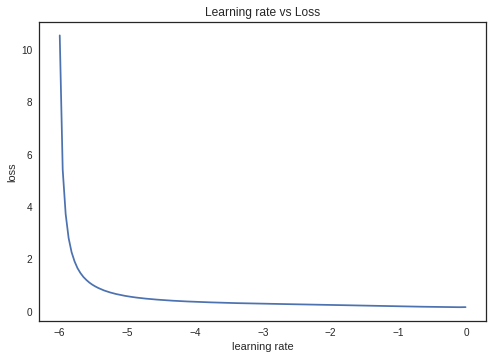

In [27]:
from clr import LRFinder

num_samples = X_train.shape[0]
minimum_lr = 1e-6
maximum_lr = 10


lr_callback = LRFinder(num_samples, batch_size,
                       minimum_lr, maximum_lr,
                       # validation_data=(X_val, Y_val),
                       lr_scale='exp', save_dir='/content')

# Ensure that number of epochs = 1 when calling fit()
model.fit(X_train, y_train, epochs=1, batch_size=batch_size, callbacks=[lr_callback])
lr_callback.plot_schedule()

# Train

In [93]:
from clr import OneCycleLR
max_lr = 0.1
lr_manager = OneCycleLR(num_samples, batch_size, max_lr,
                        end_percentage=0.1, scale_percentage=None,
                        maximum_momentum=0.95, minimum_momentum=0.85)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=300, 
                    # callbacks=[checkpoints, lr_finder],
                    # callbacks=[lr_finder],
                    callbacks=[checkpoints, lr_manager],
                    validation_data=(X_val, y_val))  

Epoch 1/300
time_linear shape (None, 128, 1)
time_periodic shape (None, 128, 3)
time2vec out shape (None, 128, 4)
time_linear shape (None, 128, 1)
time_periodic shape (None, 128, 3)
time2vec out shape (None, 128, 4)
  6/142 [>.............................] - ETA: 31s - loss: 0.1821 - mae: 0.4245 - mape: 91.0108WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0024s vs `on_train_batch_end` time: 1.0355s). Check your callbacks.


142/142 [==============================] - ETA: 0s - loss: 0.0202 - mae: 0.0881 - mape: 18.7781time_linear shape (None, 128, 1)
time_periodic shape (None, 128, 3)
time2vec out shape (None, 128, 4)

Epoch 00001: val_loss improved from inf to 0.00053, saving model to /content/Transformers_eth+btc.hdf5
 - lr: 0.01066 - momentum: 0.95 
142/142 [==============================] - 64s 279ms/step - loss: 0.0202 - mae: 0.0881 - mape: 18.7781 - val_loss: 5.3330e-04 - val_mae: 0.0170 - val_mape: 3.6060
Epoch 2/300
142/142 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0234 - mape: 5.1671
Epoch 00002: val_loss did not improve from 0.00053
 - lr: 0.01133 - momentum: 0.95 
142/142 [==============================] - 33s 234ms/step - loss: 0.0011 - mae: 0.0234 - mape: 5.1671 - val_loss: 5.3383e-04 - val_mae: 0.0170 - val_mape: 3.6072
Epoch 3/300
142/142 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0234 - mape: 5.1669
Epoch 00003: val_loss did not improve from 

# Display Results

In [35]:
model = tf.keras.models.load_model('/content/Transformers_eth+btc.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

time_linear shape (None, 128, 2, 1)
time_periodic shape (None, 128, 2, 3)
time2vec out shape (None, 128, 2, 4)


In [37]:
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

time_linear shape (None, 128, 2, 1)
time_periodic shape (None, 128, 2, 3)
time2vec out shape (None, 128, 2, 4)
time_linear shape (None, 128, 2, 1)
time_periodic shape (None, 128, 2, 3)
time2vec out shape (None, 128, 2, 4)
 
Evaluation metrics
Training Data - Loss: 0.0000, MAE: 0.0012, MAPE: 0.2699
Validation Data - Loss: 0.0000, MAE: 0.0009, MAPE: 0.2623
Test Data - Loss: 0.0000, MAE: 0.0010, MAPE: 0.2115


In [ ]:
train_pred

array([[0.49695542],
       [0.40868816],
       [0.5546978 ],
       [0.67837703],
       [0.42900178],
       [0.42265615],
       [0.46611524]], dtype=float32)

In [ ]:
y_train

array([0.49700997, 0.40866506, 0.55456362, 0.67862556, 0.42891119,
       0.42270615, 0.46611052])

In [ ]:
y_train.mean()

0.49379886845516374

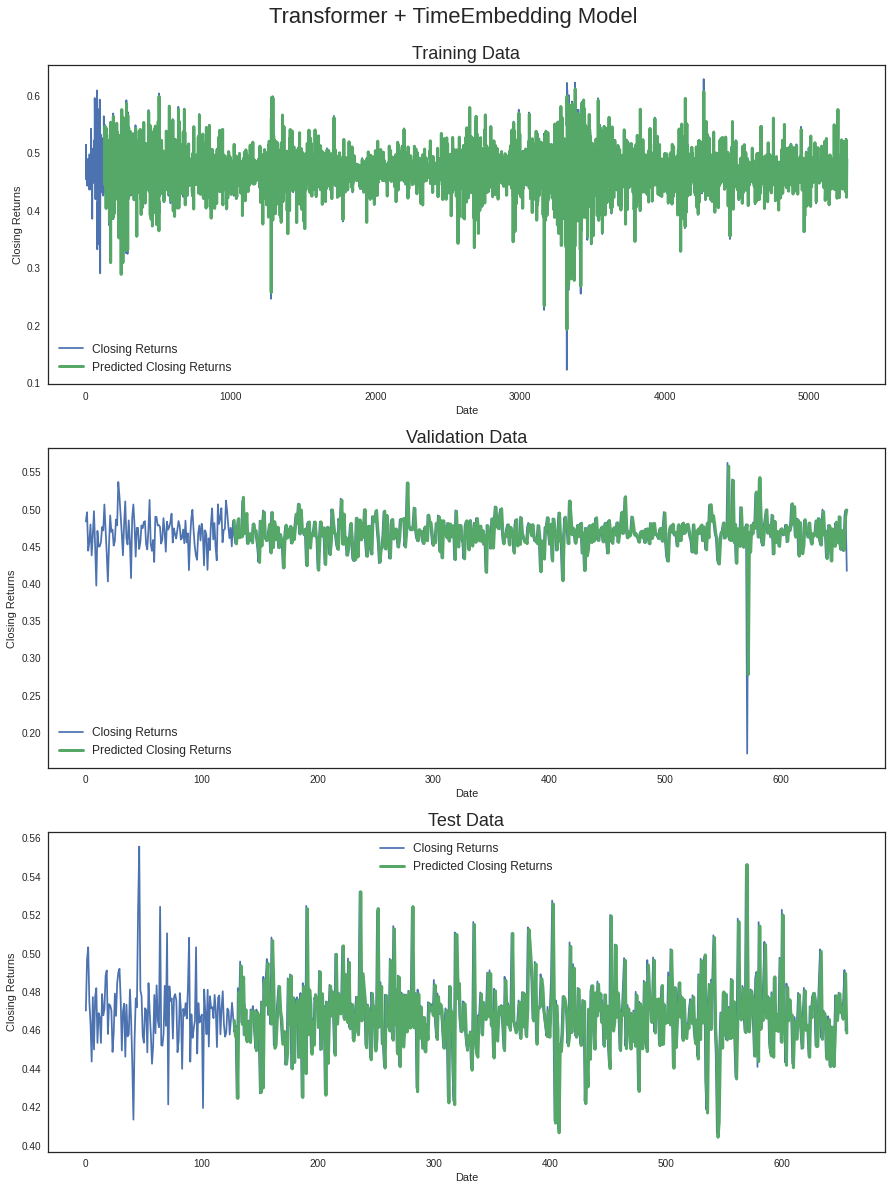

In [38]:

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 0, 3], label='Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 0, 3], label='Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 0, 3], label='Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Closing Returns')
ax31.legend(loc="best", fontsize=12)

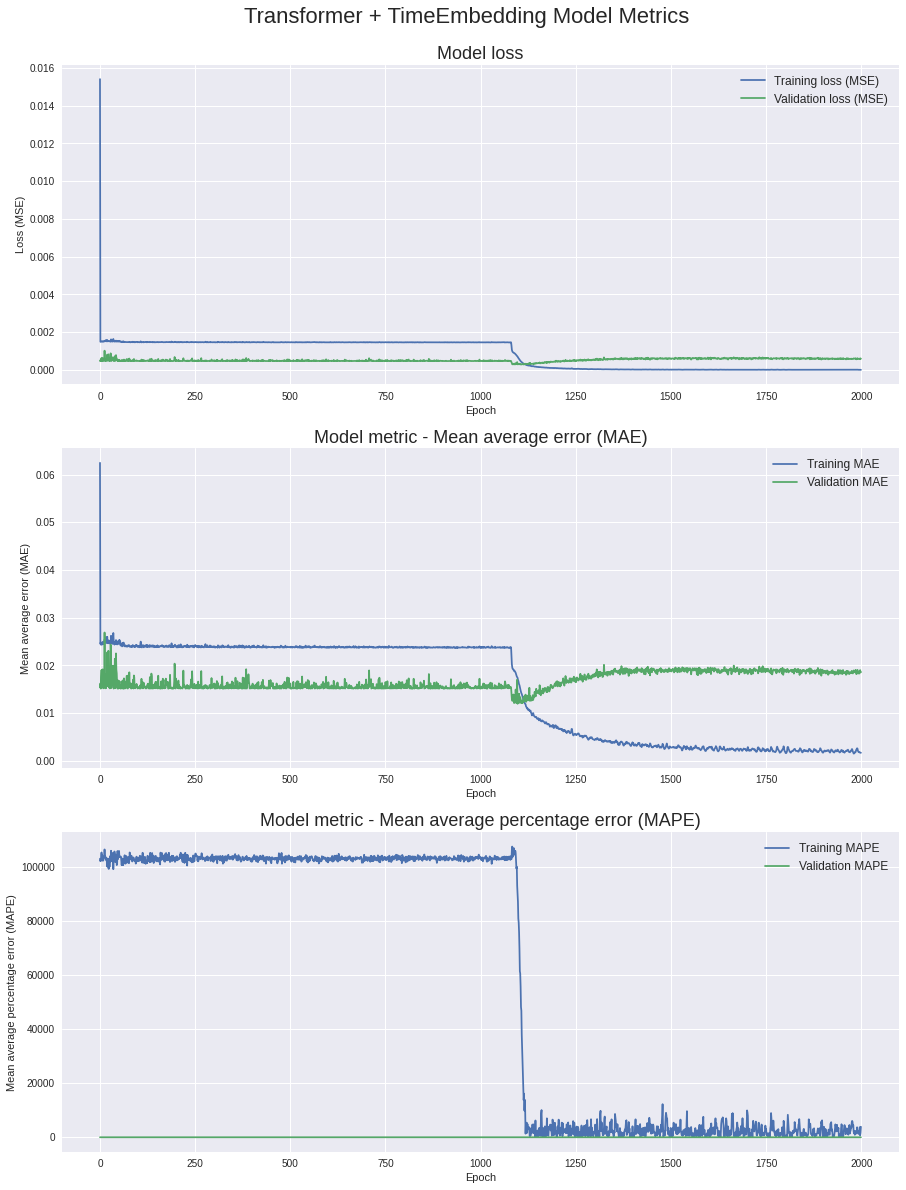

In [ ]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

In [ ]:
pd.DataFrame(data=np.concatenate([np.expand_dims(train_data[:,0,3][:10],axis=-1),
                                  train_pred[:10]], axis=-1),
             columns=["close", "predicted"])

,close,predicted
0,0.467478,0.462462
1,0.479457,0.460911
2,0.497906,0.452887
3,0.470614,0.486882
4,0.455317,0.532344
5,0.467445,0.457139
6,0.460346,0.450284
7,0.458311,0.458775
8,0.437312,0.480676
9,0.479148,0.508578


In [ ]:
train_data[:,0,3][:10]

array([0.46747844, 0.47945727, 0.49790615, 0.47061439, 0.45531701,
       0.46744495, 0.46034638, 0.45831095, 0.43731218, 0.47914779])

In [ ]:
df.iloc[:10]

,volume,close,high,low,open
timestamp,,,,,
2021-01-01 00:00:00,0.058924,0.467478,0.467478,0.467478,0.467478
2021-01-01 01:00:00,0.030490,0.514778,0.500360,0.479457,0.460079
2021-01-01 02:00:00,0.022086,0.454534,0.467445,0.497906,0.514710
2021-01-01 03:00:00,0.040044,0.470107,0.462517,0.470614,0.454501
2021-01-01 04:00:00,0.046740,0.458536,0.466385,0.455317,0.469575
2021-01-01 05:00:00,0.107250,0.462007,0.454446,0.467445,0.458966
2021-01-01 06:00:00,0.014692,0.464168,0.467478,0.460346,0.462173
2021-01-01 07:00:00,0.157209,0.459108,0.459378,0.458311,0.465211
2021-01-01 08:00:00,0.192277,0.443961,0.459619,0.437312,0.458168


## Model architecture overview

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="IBM_Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)